In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# !pip install 'shimmy>=0.2.1'
# !pip install git+https://github.com/DLR-RM/stable-baselines3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import torch
from gym.utils import seeding
import gym
from gym import spaces
import ast
import warnings
warnings.simplefilter("ignore")

Mounted at /content/drive


In [ ]:
ROOT_PATH = '/content/drive/MyDrive/How To Get Rich Quick (with RL)'
directory = ROOT_PATH + '/data/'
coins = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']
df_close = pd.read_csv(directory + 'df_close.csv')
df_close.open_time_ms = pd.to_datetime(df_close['open_time_ms'])
df_close = df_close.iloc[:,:-1]
df_close

,open_time_ms,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close
0,2022-01-01 00:00:00,1.3140,32.810,109.98,512.9,46321.34,0.17050,26.750,3690.09,19.570,146.40,2.5410,0.000033,170.40,0.07552,17.080,0.8334
1,2022-01-01 00:05:00,1.3160,32.580,110.06,513.3,46371.11,0.17030,26.800,3696.55,19.580,146.60,2.5450,0.000033,170.60,0.07538,17.090,0.8330
2,2022-01-01 00:10:00,1.3170,32.460,110.07,513.5,46332.51,0.17050,26.840,3691.90,19.600,146.70,2.5460,0.000033,170.85,0.07538,17.110,0.8322
3,2022-01-01 00:15:00,1.3170,32.470,109.95,513.5,46293.90,0.17030,26.770,3689.51,19.570,146.60,2.5360,0.000033,171.07,0.07531,17.080,0.8319
4,2022-01-01 00:20:00,1.3220,32.770,110.61,514.3,46395.53,0.17090,26.950,3699.45,19.640,147.00,2.5480,0.000034,171.20,0.07553,17.100,0.8349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127995,2023-03-21 10:15:00,0.3390,11.570,16.94,333.9,28058.54,0.07194,6.138,1755.25,7.030,80.52,1.1141,0.000011,22.27,0.06588,6.192,0.3885
127996,2023-03-21 10:20:00,0.3402,11.619,16.97,334.4,28101.02,0.07224,6.167,1762.44,7.044,80.82,1.1282,0.000011,22.39,0.06594,6.214,0.3882
127997,2023-03-21 10:25:00,0.3395,11.612,16.95,334.2,28044.52,0.07209,6.158,1758.71,7.042,80.66,1.1239,0.000011,22.32,0.06588,6.209,0.3888
127998,2023-03-21 10:30:00,0.3388,11.604,16.95,334.2,28049.77,0.07203,6.155,1757.78,7.049,80.44,1.1219,0.000011,22.32,0.06588,6.207,0.3873


In [ ]:
pd.DataFrame(df_close['UNI_close'].head(30))

,UNI_close
0,17.08
1,17.09
2,17.11
3,17.08
4,17.10
5,17.04
6,17.04
7,17.13
8,17.18
9,17.21


In [24]:
def baseline_trader(asset, short_window, long_window, n_units, start_amt):
  signals = pd.DataFrame()

  # `center = false` basically computes mean on everything from before the current timestep
  # `min_periods = 1`. If fewer than `window` periods, calculate moving avg based on what we have currently
  signals['close_price'] = df_close[asset]
  signals['short_mavg'] = df_close[asset].rolling(window=short_window, min_periods=1, center=False).mean()
  signals['long_mavg'] = df_close[asset].rolling(window=long_window, min_periods=1, center=False).mean()
  pd.DataFrame(signals['short_mavg']).head(30)

  # Generate signals
  signals['crossover'] = np.NaN
  signals['crossover'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

  # Generate trading orders
  signals['positions'] = signals['crossover'].diff()

  # Buy signals are marked with 1.0 in the 'positions' column
  buy_signals = signals[signals['positions'] == 1.0]

  # Sell signals are marked with -1.0 in the 'positions' column
  sell_signals = signals[signals['positions'] == -1.0]

  signals['cash'] = 0.0
  signals['asset_qty'] = 0.0

  cash = start_amt
  asset_qty = 0.0
  unit_cost = 0.0  # The cost of last bought unit

  for i in range(len(signals)):
      # Check if we have a buy signal and enough cash to make a buy
      if signals['positions'].iloc[i] == 1.0 and cash >= signals['close_price'].iloc[i]*n_units:
          unit_cost = signals['close_price'].iloc[i]
          asset_qty += n_units
          cash -= unit_cost*n_units
      
      # Check if we have a sell signal and enough asset_qty
      elif signals['positions'].iloc[i] == -1.0 and asset_qty >= n_units:
          asset_qty -= n_units
          cash += signals['close_price'].iloc[i]*n_units
      
      # Check if we have a hold signal and enough cash (not enough cash => sell)
      elif signals['positions'].iloc[i] == 0.0 and cash < unit_cost*n_units:
          # Check if we have sufficient asset_qty to make a sell
          if asset_qty >= n_units:
              asset_qty -= n_units
              cash += signals['close_price'].iloc[i]*n_units
      
      # Store the cash and asset quantity
      signals['cash'].iloc[i] = cash
      signals['asset_qty'].iloc[i] = asset_qty

  # Calculate total portfolio value
  signals['total_value'] = signals['cash'] + signals['asset_qty']*signals['close_price']

  # Calculate returns based on total portfolio value
  signals['returns'] = signals['total_value'].pct_change()
  signals['returns'] = signals['returns']+1
  # signals_25 = signals[short_window:]

  return signals

In [43]:
# Assume starting amount is equally distributed between all crypto assets
start_amt = 1e4/(df_close.shape[1]-1)
print('The starting amount to invest per crypto asset = ', start_amt)
assets = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']
asset_returns = pd.DataFrame()

for asset in assets:
  asset_close = asset + '_close'
  signals = baseline_trader(asset_close, 25, 50, 10, start_amt)
  asset_returns[asset] = signals.returns

asset_returns.index = signals.index

The starting amount to invest per crypto asset =  625.0


In [46]:
asset_returns
return_means = asset_returns.mean(axis=1)
return_means[25:]

25        1.000000
26        1.000000
27        1.000000
28        1.000000
29        1.000000
            ...   
127995    1.000056
127996    1.000054
127997    0.999969
127998    0.999984
127999    0.999911
Length: 127975, dtype: float64

In [ ]:
# # Buy signals are marked with 1.0 in the 'positions' column
# buy_signals = signals[signals['positions'] == 1.0]

# # Sell signals are marked with -1.0 in the 'positions' column
# sell_signals = signals[signals['positions'] == -1.0]

# start_amt = 1e4/(df_close.shape[1]-1)
# signals['cash'] = 0.0
# signals['asset_qty'] = 0.0

# cash = start_amt
# asset_qty = 0.0
# n_units = 10
# unit_cost = 0.0  # The cost of last bought unit

# for i in range(len(signals)):
#     # Check if we have a buy signal and enough cash to make a buy
#     if signals['positions'].iloc[i] == 1.0 and cash >= signals['close_price'].iloc[i]*n_units:
#         unit_cost = signals['close_price'].iloc[i]
#         asset_qty += n_units
#         cash -= unit_cost*n_units
    
#     # Check if we have a sell signal and enough asset_qty
#     elif signals['positions'].iloc[i] == -1.0 and asset_qty >= n_units:
#         asset_qty -= n_units
#         cash += signals['close_price'].iloc[i]*n_units
    
#     # Check if we have a hold signal and enough cash (not enough cash => sell)
#     elif signals['positions'].iloc[i] == 0.0 and cash < unit_cost*n_units:
#         # Check if we have sufficient asset_qty to make a sell
#         if asset_qty >= n_units:
#             asset_qty -= n_units
#             cash += signals['close_price'].iloc[i]*n_units
    
#     # Store the cash and asset quantity
#     signals['cash'].iloc[i] = cash
#     signals['asset_qty'].iloc[i] = asset_qty

# # Calculate total portfolio value
# signals['total_value'] = signals['cash'] + signals['asset_qty']*signals['close_price']

# # Calculate returns based on total portfolio value
# signals['returns'] = signals['total_value'].pct_change()
# signals['returns'] = signals['returns']+1
# signals_25 = signals[short_window:]

# # Compute 5-period moving average of returns
# signals['returns_mavg'] = signals['returns'].rolling(window=5, center=False).mean()

In [ ]:
signals.head(30)

,close_price,short_mavg,long_mavg,crossover,positions,cash,asset_qty,total_value,returns,returns_mavg
0,17.08,17.080000,17.080000,NaN,NaN,625.0,0.0,625.0,NaN,NaN
1,17.09,17.085000,17.085000,NaN,NaN,625.0,0.0,625.0,1.0,NaN
2,17.11,17.093333,17.093333,NaN,NaN,625.0,0.0,625.0,1.0,NaN
3,17.08,17.090000,17.090000,NaN,NaN,625.0,0.0,625.0,1.0,NaN
4,17.10,17.092000,17.092000,NaN,NaN,625.0,0.0,625.0,1.0,NaN
5,17.04,17.083333,17.083333,NaN,NaN,625.0,0.0,625.0,1.0,1.0
6,17.04,17.077143,17.077143,NaN,NaN,625.0,0.0,625.0,1.0,1.0
7,17.13,17.083750,17.083750,NaN,NaN,625.0,0.0,625.0,1.0,1.0
8,17.18,17.094444,17.094444,NaN,NaN,625.0,0.0,625.0,1.0,1.0
9,17.21,17.106000,17.106000,NaN,NaN,625.0,0.0,625.0,1.0,1.0


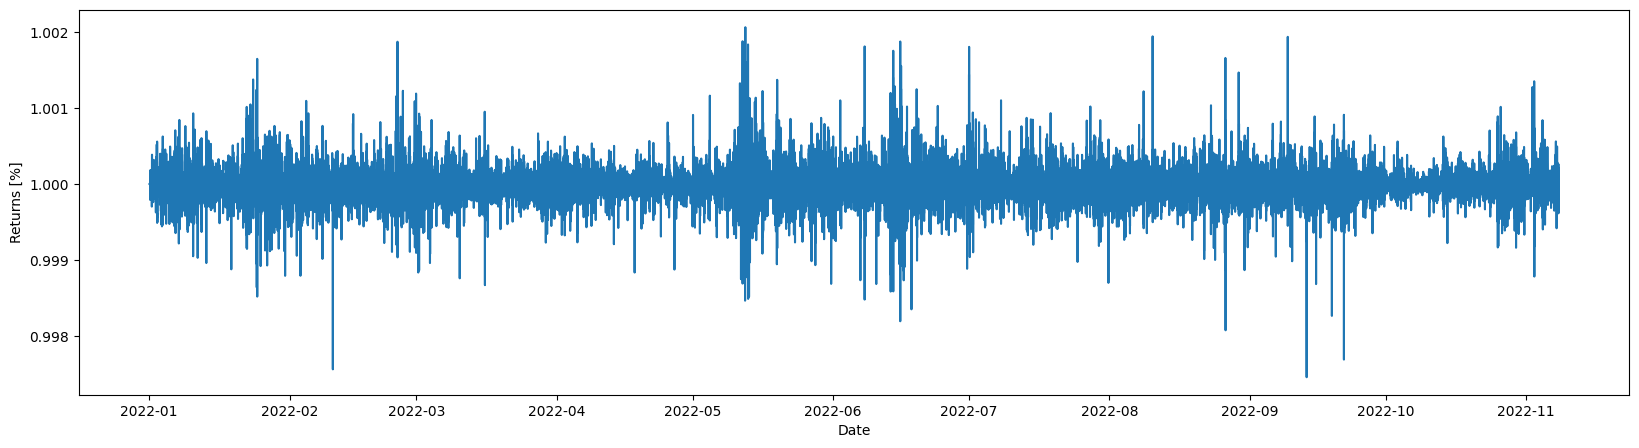

In [48]:
plt.figure(figsize = (20,5))
plt.plot(df_close['open_time_ms'][25:89582+25], return_means[25:89582+25])
plt.xlabel('Date')
plt.ylabel('Returns [%]')
plt.show()

In [ ]:
def moving_average_crossover_strategy(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    assets = ['ADA_close', 'ATOM_close', 'AVAX_close', 'BNB_close', 'BTC_close', 'DOGE_close', 'DOT_close', 'ETH_close', 'LINK_close', 'LTC_close', 'MATIC_close', 'SHIB_close', 'SOL_close', 'TRX_close', 'UNI_close', 'XRP_close']

    # Calculate the short and long moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()

    return signals

# Usage example
short_window = 10
long_window = 50

# `data` should be a pandas DataFrame with a 'Close' column containing the closing prices of the cryptocurrency
data = pd.read_csv('crypto_prices.csv', index_col='Date', parse_dates=True)
signals = moving_average_crossover_strategy(data, short_window, long_window)

# Buy signals are marked with 1.0 in the 'positions' column
buy_signals = signals[signals['positions'] == 1.0]

# Sell signals are marked with -1.0 in the 'positions' column
sell_signals = signals[signals['positions'] == -1.0]

print("Buy signals:\n", buy_signals)
print("Sell signals:\n", sell_signals)
